# Self-Driving Car
## Project 4: **Advanced Lane Finding**
### Kimon Roufas

***
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [12]:
#importing some useful packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pprint
from random import randint
from collections import deque
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

print('Numpy version: {}'.format(np.__version__))
print('OpenCV version: {}'.format(cv2.__version__))
print('MatPlotLib version: {}'.format(matplotlib.__version__))

Numpy version: 1.13.1
OpenCV version: 3.1.0
MatPlotLib version: 2.0.2


## Camera Calibration
### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is shown below. I wrote a helper function (`get_object_points_and_image_points(images)`) that takes a list of image file names, reads them in and returns the object points and image points. A second function, `calc_camera_coefficients(objpoints, imgpoints)`, calculates the camera calibration coefficients and then `undistort(img, calibration)` will undistort any image.

One of the calibration images did not contain all 6 rows of corners so I had to eliminate it from the calibration set.

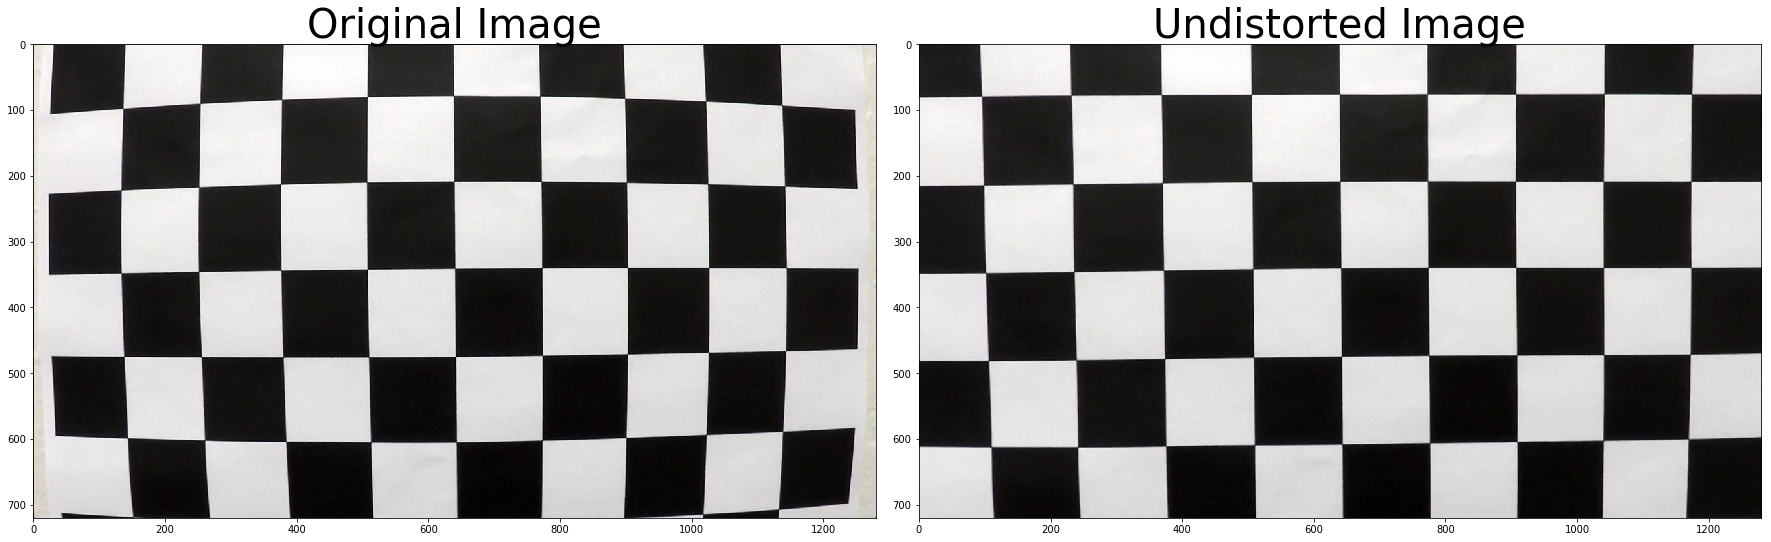

In [13]:
def get_object_points_and_image_points(images):
    # arrays to store object points and image points from all teh images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points, like (0,0,0), (1, 0, 0), (2, 0, 0), etc...
    nx, ny = (9, 6)
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x, y coordinates

    for fname in images:
        # read in each image
        img = mpimg.imread(fname)
        # convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # if corners are found, add the object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        return (objpoints, imgpoints)

    
def calc_camera_coefficients(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    return (mtx, dist) if ret else None
    

def undistort(img, calibration):
    mtx, dist = calibration
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


def display_two_images(img1, title1, img2, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title(title1, fontsize=40)
    ax1.imshow(img1)
    ax2.set_title(title2, fontsize=40)
    ax2.imshow(img2)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# images = glob.glob('./camera_cal/calibration*.jpg')
images = [
    './camera_cal/calibration2.jpg',
    './camera_cal/calibration3.jpg',
    './camera_cal/calibration4.jpg',
    './camera_cal/calibration5.jpg',
    './camera_cal/calibration6.jpg',
    './camera_cal/calibration7.jpg',
    './camera_cal/calibration8.jpg',
    './camera_cal/calibration9.jpg',
    './camera_cal/calibration10.jpg',
    './camera_cal/calibration11.jpg',
    './camera_cal/calibration12.jpg',
    './camera_cal/calibration13.jpg',
    './camera_cal/calibration14.jpg',
    './camera_cal/calibration15.jpg',
    './camera_cal/calibration16.jpg',
    './camera_cal/calibration17.jpg',
    './camera_cal/calibration18.jpg',
    './camera_cal/calibration19.jpg',
    './camera_cal/calibration20.jpg'
]
objpoints, imgpoints = get_object_points_and_image_points(images)

# show a sample image that has been undistorted using the calibration coefficients
img = mpimg.imread('./camera_cal/calibration1.jpg')
calibration = calc_camera_coefficients(img, objpoints, imgpoints)
undistorted = undistort(img, calibration)
display_two_images(img, 'Original Image', undistorted, 'Undistorted Image')


## Helper Functions

In [14]:
images = [
    './test_images/straight_lines1.jpg',
    './test_images/straight_lines2.jpg',
    './test_images/test1.jpg',
    './test_images/test2.jpg',
    './test_images/test3.jpg',
    './test_images/test4.jpg',
    './test_images/test5.jpg'
]
test_images = []
for fname in images:
    test_images.append(mpimg.imread(fname))
straight_lines1, straight_lines2, test1, test2, test3, test4, test5 = test_images


def threshold_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return (color_binary, combined_binary)


def get_warper_coordinates(img_shape):
    max_x, max_y = (img_shape[1], img_shape[0])
    src = np.float32(
        [[max_x / 2 - 60, max_y / 2 + 100],
        [((max_x / 6) - 0), max_y],
        [(max_x * 5 / 6) + 50, max_y],
        [(max_x / 2 + 60), max_y / 2 + 100]])
    dst = np.float32(
        [[(max_x / 4), 0],
        [(max_x / 4), max_y],
        [(max_x*3/4), max_y],
        [(max_x*3/4), 0]])
    return (src, dst)
    

def warper(img):
    img_size = (img.shape[1], img.shape[0])
    src, dst = get_warper_coordinates(img.shape)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return (warped, M, Minv)


def draw_lines(img:np.array, pts:np.array):
    new_img = np.copy(img)
    cv2.polylines(new_img, np.int32([pts]), False, (255,0,0), 3)
    return new_img

## Pipeline (single images)

### 1. Provide an example of a distortion-corrected image.

To demonstrate this step, I have applied 

I will describe how I apply the distortion correction to one of the test images like this one:

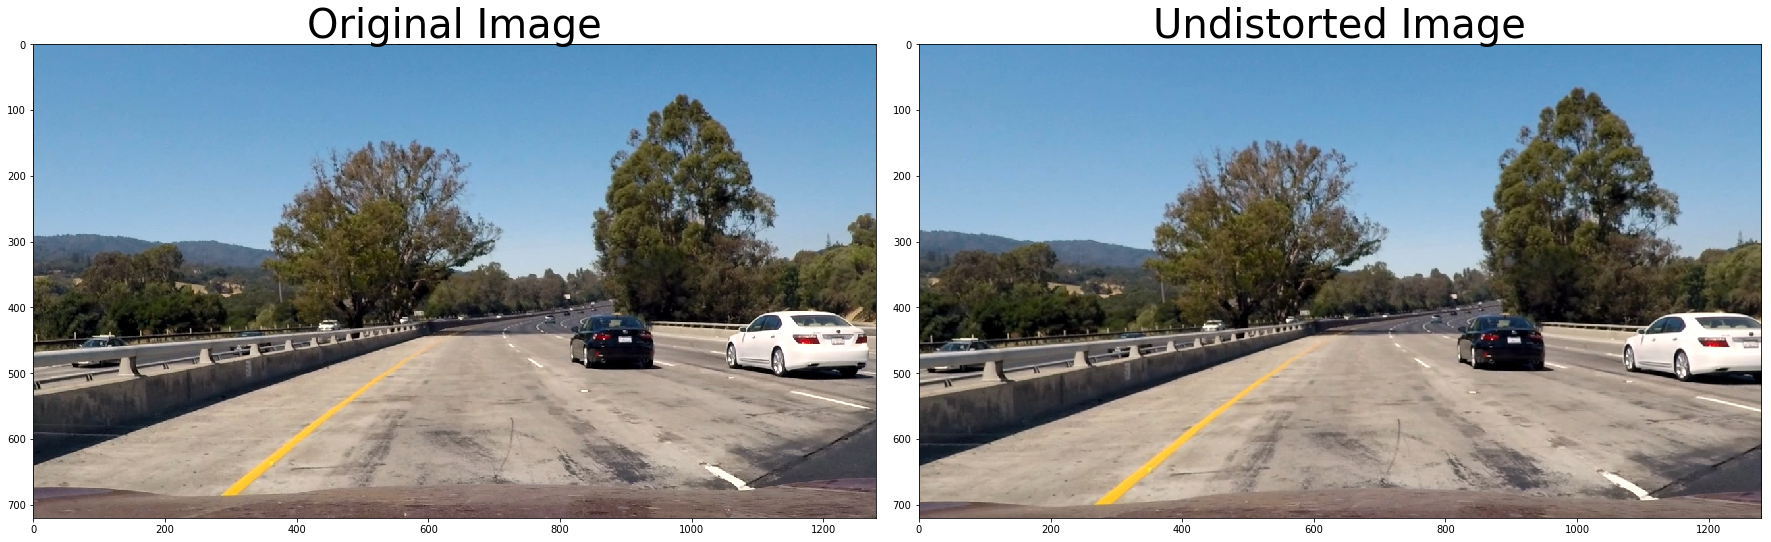

In [15]:
undistorted1 = undistort(test1, calibration)
display_two_images(test1, 'Original Image', undistorted1, 'Undistorted Image')

### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image (see `threshold_binary()` above).  Here's an example of my output for this step. The left image uses two colors to show the contribution of the gradient and color thresholding separately. The right image combines the two for the final result.

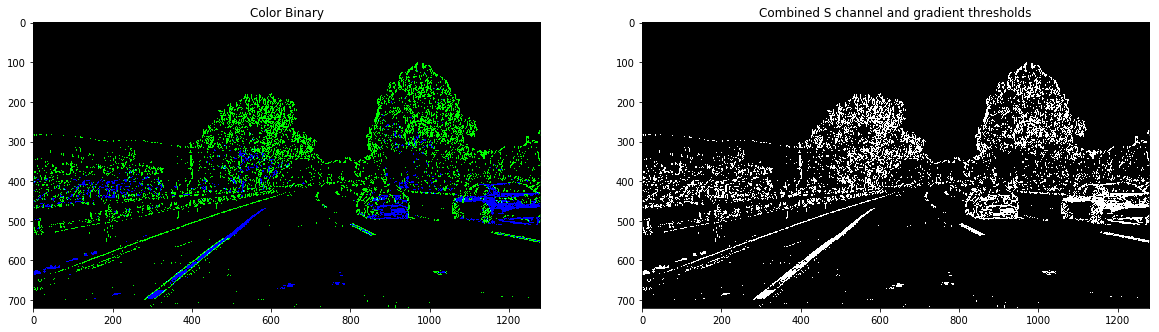

In [16]:
undistorted = undistort(test4, calibration)
color_binary, threshold_binary_image = threshold_binary(undistorted)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Color Binary')
ax1.imshow(color_binary)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(threshold_binary_image, cmap='gray')

### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a couple functions breaking apart the problem into getting the perspective change source and destination coordinates (`get_warper_coordinates()`), and warping an image (`warper()`). The definitions of these functions are above int the **Helper** section. An additional helper to draw the lines (`draw_lines()`) from the coordinates was written as well.

These functions were used to generate the example images below. The coordinates used for the transformation are also shown below. I verified that my perspective transform was working correctly by adding the lines to copies of the images


Source coordinates (src):
array([[ 580,  460],
       [ 213,  720],
       [1116,  720],
       [ 700,  460]], dtype=int32)

Destination coordinates (dst):
array([[320,   0],
       [320, 720],
       [960, 720],
       [960,   0]], dtype=int32)


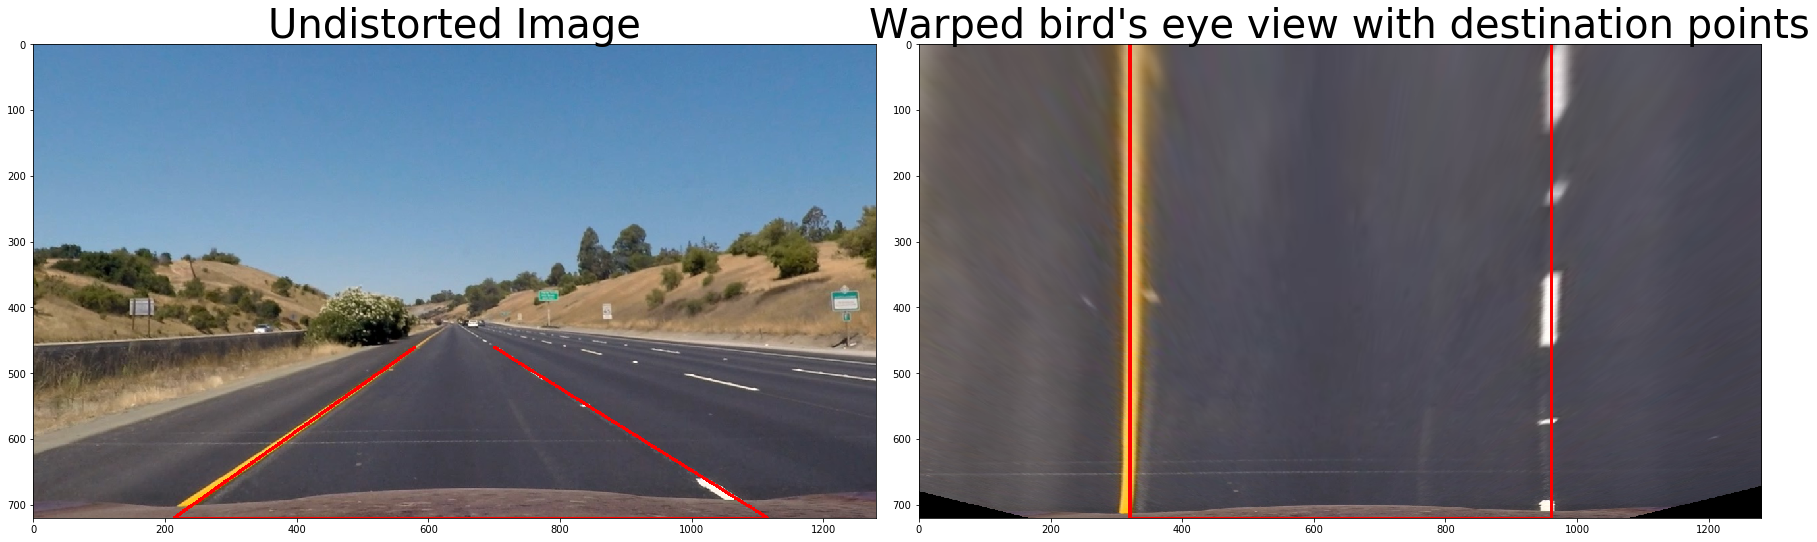

In [17]:
test_image = np.copy(straight_lines1)
src, dst = get_warper_coordinates(test_image.shape)

print('Source coordinates (src):')
pprint.pprint(np.int32(src))
print('\nDestination coordinates (dst):')
pprint.pprint(np.int32(dst))

undistorted = undistort(test_image, calibration)
undistorted_with_lines = draw_lines(undistorted, src)
warped, M, Minv = warper(undistorted)
warped_with_lines = draw_lines(warped, dst)

# display the test images
display_two_images(undistorted_with_lines, 'Undistorted Image', warped_with_lines, 'Warped bird\'s eye view with destination points')

### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

At this point I am unsure which of the two methods discussed in the class will obtain the best lane line polynomials. So I implemented both of them. The code for each is in the two sections that follow, and the output is shown for the same example image right after.

In [18]:
# some parameters

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

(720, 0)

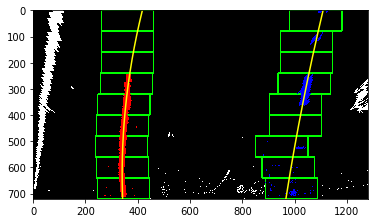

In [19]:
def fit_polynomial_lanes(binary_warped, draw_boxes=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_boxes:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_fit_in_meters = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_in_meters = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)


    return (out_img, left_fit, right_fit, left_fit_in_meters, right_fit_in_meters, nonzeroy, nonzerox, left_lane_inds, right_lane_inds)



# EXAMPLE IMAGE
test_image = np.copy(test1)
undistorted = undistort(test_image, calibration)
color_binary, threshold_binary_image = threshold_binary(undistorted)
binary_warped, M, Minv = warper(threshold_binary_image)
out_img, left_fit, right_fit, left_fit_in_meters, right_fit_in_meters, nonzeroy, nonzerox, left_lane_inds, right_lane_inds = fit_polynomial_lanes(binary_warped, draw_boxes=True)



# Generate x and y values for plotting
def generate_x_and_y_from_polylines(left_fit, right_fit):
    plot_y = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fit_x = left_fit[0]*plot_y**2 + left_fit[1]*plot_y + left_fit[2]
    right_fit_x = right_fit[0]*plot_y**2 + right_fit[1]*plot_y + right_fit[2]
    return (left_fit_x, right_fit_x, plot_y)

left_fitx, right_fitx, ploty = generate_x_and_y_from_polylines(left_fit, right_fit)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
# return a binary image same size as reference with a rectangle (the window)
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output


def find_window_centroids(image, window_width, window_height, margin):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


# Fit a second order polynomial to each set of centroid windows
def fit_polynomial_lanes_from_centroids(window_centroids):
    left_fit = right_fit = None
    if (len(window_centroids) > 0):
        l_x_coords = []
        r_x_coords = []
        y_coords = []

        # Go through each level and create a list of centroid center coordinates
        for level in range(0, len(window_centroids)):
            l_x = window_centroids[level][0]
            r_x = window_centroids[level][1]
            y = max_y - (window_height / 2 + window_height * level)
            l_x_coords.append(l_x)
            r_x_coords.append(r_x)
            y_coords.append(y)

        left_fit = np.polyfit(y_coords, l_x_coords, 2)
        right_fit = np.polyfit(y_coords, r_x_coords, 2)
    
    return (left_fit, right_fit)


# # EXAMPLE IMAGE
# # test_image = np.copy(straight_lines1)
# test_image = np.copy(test1)
# undistorted = undistort(test_image, calibration)
# color_binary, threshold_binary_image = threshold_binary(undistorted)
# binary_warped, M, Minv = warper(threshold_binary_image)

# # Read in a thresholded image
# warped = binary_warped
# img_shape = binary_warped.shape
# max_x, max_y = (img_shape[1], img_shape[0])

# # PARAMETERS: window settings
# window_width = 50 
# window_height = 80 # Break image into 9 vertical layers since image height is 720
# margin = 100 # How much to slide left and right for searching


# window_centroids = find_window_centroids(warped, window_width, window_height, margin)
# # print(len(window_centroids))
# # pprint.pprint(window_centroids)
# left_fit, right_fit = fit_polynomial_lanes_from_centroids(window_centroids)
# # print(left_fit)
# # print(right_fit)




# # Generate x and y values for plotting
# ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# out_img = np.copy(binary_warped)
# # out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# # out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
# plt.imshow(out_img, cmap='gray')
# plt.plot(left_fitx, ploty, color='red')
# plt.plot(right_fitx, ploty, color='red')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)





# # If we found any window centers
# if len(window_centroids) > 0:

#     # Points used to draw all the left and right windows
#     l_points = np.zeros_like(warped)
#     r_points = np.zeros_like(warped)

#     # Go through each level and draw the windows
#     for level in range(0,len(window_centroids)):
#         # Window_mask is a function to draw window areas
#         l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
#         r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
#         # Add graphic points from window mask here to total pixels found 
#         l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
#         r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

#     # Draw the results
#     template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
#     zero_channel = np.zeros_like(template) # create a zero color channel
#     template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
#     warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
#     output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# # If no window centers found, just display orginal road image
# else:
#     output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# # Display the final results
# plt.imshow(output, cmap='gray')
# plt.title('window fitting results')
# plt.show()


### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

Below are two helper functions to calculate the radii of curviture in pixel space and in real world space (in meters). Following those, are the calculated values for the last test images above. The values are reasonable.

In [24]:
def calculate_curvature_in_pixels(polynomial_fit, y_eval):
    curve_radius = ((1 + (2*polynomial_fit[0]*y_eval + polynomial_fit[1])**2)**1.5) / np.absolute(2*polynomial_fit[0])
    return curve_radius


def calculate_curvature_in_meters(polynomial_fit_in_meters, y_eval, ym_per_pix):
    curve_radius = ((1 + (2*polynomial_fit_in_meters[0]*y_eval*ym_per_pix + polynomial_fit_in_meters[1])**2)**1.5) / np.absolute(2*polynomial_fit_in_meters[0])
    return curve_radius


# PIXEL SPACE EXAMPLE CURVATURE CALCULATION
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
img_shape = binary_warped.shape
max_x, max_y = (img_shape[1], img_shape[0])
y_eval = max_y
left_curve_radius_in_pixels = calculate_curvature_in_pixels(left_fit, y_eval)
right_curve_radius_in_pixels = calculate_curvature_in_pixels(right_fit, y_eval)
print('left: {0:.0f}, right: {1:.0f} (in pixel space)'.format(left_curve_radius_in_pixels, right_curve_radius_in_pixels))
# Example values: 1926.74 1908.48


# REAL WORLD SPACE EXAMPLE CURVATURE CALCULATION
left_curve_radius_in_meters = calculate_curvature_in_meters(left_fit_in_meters, y_eval, ym_per_pix)
right_curve_radius_in_meters = calculate_curvature_in_meters(right_fit_in_meters, y_eval, ym_per_pix)
print('left: {0:.1f}m, right: {1:.1f}m (in real world space)'.format(left_curve_radius_in_meters, right_curve_radius_in_meters))
# Example values: 632.1 m    626.2 m


left: 2541, right: 9251 (in pixel space)
left: 832.8m, right: 2931.5m (in real world space)


### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in the function `add_lane_lines_to_image()` shown below. An example follows.

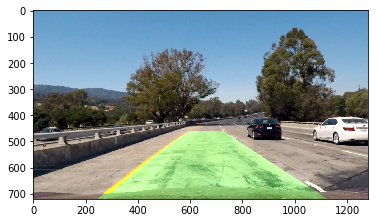

In [26]:
def add_lane_lines_to_image(base_image, left_plot_x, right_plot_x, plot_y):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(base_image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_plot_x, plot_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_plot_x, plot_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (base_image.shape[1], base_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(base_image, 1, newwarp, 0.3, 0)
    return result


result = add_lane_lines_to_image(undistorted, left_fitx, right_fitx, ploty)
plt.imshow(result)

## Pipeline (video)

### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)



In [27]:
def clear_state():
    return None


def lane_line_pipeline(image:np.array) -> np.array:
    undistorted = undistort(image, calibration)
    color_binary, threshold_binary_image = threshold_binary(undistorted)
    
    undistorted = undistort(image, calibration)
    color_binary, threshold_binary_image = threshold_binary(undistorted)
    binary_warped, M, Minv = warper(threshold_binary_image)
    out_img, left_fit, right_fit, left_fit_in_meters, right_fit_in_meters, nonzeroy, nonzerox, left_lane_inds, right_lane_inds = fit_polynomial_lanes(binary_warped, draw_boxes=False)

    img_shape = image.shape
    max_x, max_y = (img_shape[1], img_shape[0])
    y_eval = max_y
    left_curve_radius_in_meters = calculate_curvature_in_meters(left_fit_in_meters, y_eval, ym_per_pix)
    right_curve_radius_in_meters = calculate_curvature_in_meters(right_fit_in_meters, y_eval, ym_per_pix)

    left_fit_x, right_fit_x, plot_y = generate_x_and_y_from_polylines(left_fit, right_fit)

    result = add_lane_lines_to_image(undistorted, left_fit_x, right_fit_x, plot_y)
    return result
    

In [ ]:
filename = 'project_video.mp4'
output_filename = 'output_videos/'+filename
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip(filename)
# clip1 = VideoFileClip(filename).subclip(0, 1)
clear_state()
output_clip = clip1.fl_image(lane_line_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_filename, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


 43%|████▎     | 545/1261 [02:09<02:43,  4.38it/s]

## Discussion

### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  
